# Using Mobilenet

# Author-Md. Shafiur Rahman Khan

# Roll-2207701

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np
import os

11135
[ 7115  6558  6012   163  8772  3704   577  8590  8054  7349 10264  6412]


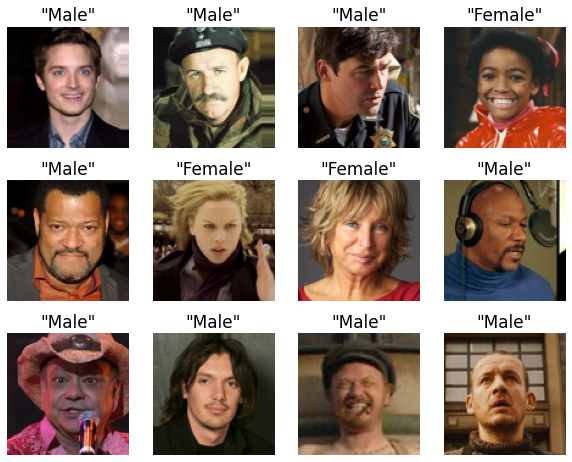

In [5]:
dataset_paths = glob.glob("C:\\Users\\User\\Desktop\\Bio Informatics Project 2022\\Md. Shafiur Rahman Khan\\Train\\Train\\**\\*.png")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
print(len(dataset_paths))
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))
print(rand)
# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)    

In [6]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

[INFO] Find 11135 images with 2 classes


In [7]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [8]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])    
        
    return model

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 10

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

In [13]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/10
1114/156 [======================================================================================================================================================================================================================] - 4s 3ms/sample - loss: 1.3588 - acc: 0.7522 - f1_m: 0.7452 - precision_m: 0.7452 - recall_m: 0.7452

Epoch 00001: saving model to License_character_recognition.h5
156/156 [==============================] - 207s 1s/step - loss: 0.5316 - acc: 0.7449 - f1_m: 0.7451 - precision_m: 0.7451 - recall_m: 0.7451 - val_loss: 1.0668 - val_acc: 0.7522 - val_f1_m: 0.7452 - val_precision_m: 0.7452 - val_recall_m: 0.7452
Epoch 2/10
1114/156 [======================================================================================================================================================================================================================] - 3s 3ms/sample - loss: 0.9963 - acc: 0.8348 - f1_m: 0.8327 - precision_m: 0.8327 - recall_m: 0.8327

Epoch 00002: s

# Accuracy-94.89%

In [14]:
import tensorflow.keras.backend as K
test_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'C:\\Users\\User\\Desktop\\Bio Informatics Project 2022\\Md. Shafiur Rahman Khan'

test_generator = test_datagen.flow_from_directory(
        path+'\\Test\\Test',  # this is the target directory
        target_size=(80,80),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 1279 images belonging to 2 classes.


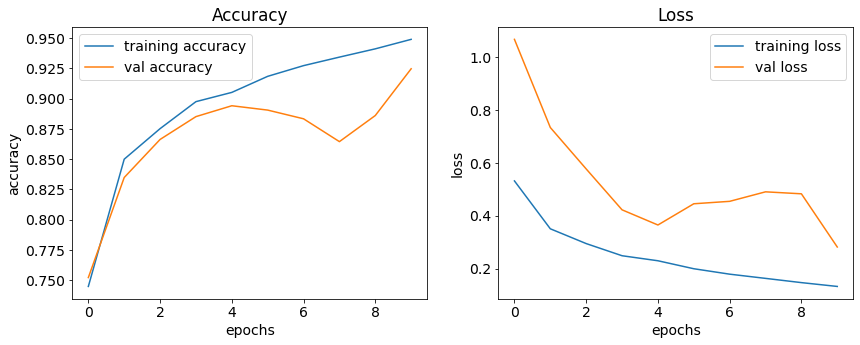

In [15]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['acc'], label='training accuracy')
plt.plot(result.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

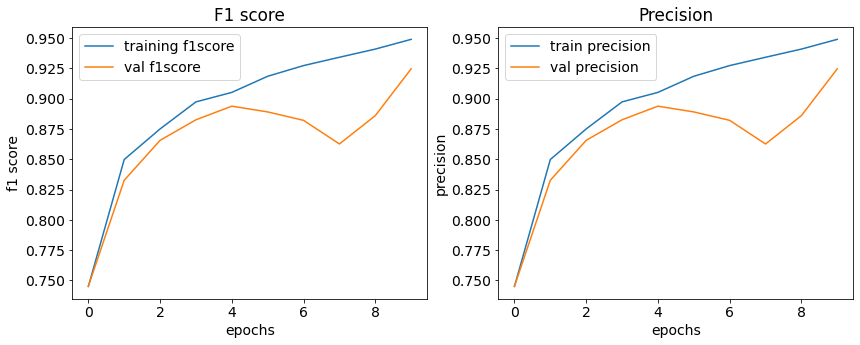

In [16]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['f1_m'], label='training f1score')
plt.plot(result.history['val_f1_m'], label='val f1score')
plt.title('F1 score')
plt.xlabel('epochs')
plt.ylabel('f1 score')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['precision_m'], label='train precision')
plt.plot(result.history['val_precision_m'], label='val precision')
plt.title('Precision')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

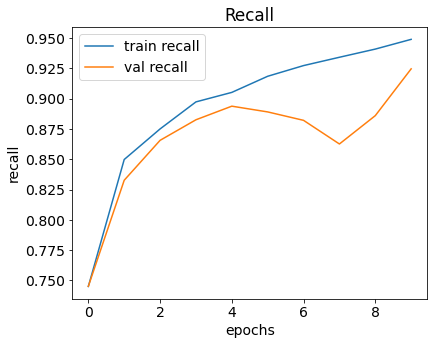

In [17]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['recall_m'], label='train recall')
plt.plot(result.history['val_recall_m'], label='val recall')
plt.title('Recall')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()

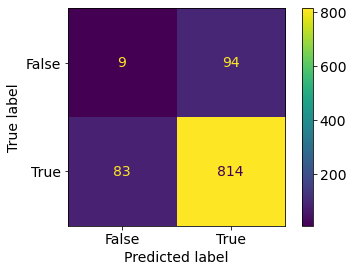

In [18]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()